## KLASIFIKASI KEADAAN MESIN MENGGUNAKAN LINEAR SVM dan RANDOM FOREST 

### IMPORT LIBRARY

In [1]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

#Kita akan menggunakan dua model
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

### IMPORT CSV

In [3]:
#Melakukan importing data yang hendak digunakan
df = pd.read_csv("predictive.csv")
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9968,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9969,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9970,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9971,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


### KITA BISA CEK KOLOM DATA

In [7]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


### CEK APAKAH ADA DATA NULL DAN DROP DATA NULL APABILA ADA
##### DALAM DATA INI ADA BEBERAPA DATA YANG TIDAK BERKECOCOKAN ANTARA TARGET DAN JENIS KERUSAKAN, OLEH KARENA ITU DATA TERSEBUT SUDAH KITA HILANGKAN TERLEBIH DAHULU

In [8]:
#Cek data null pada data kita
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

### DROP KOLOM YANG TIDAK DIGUNAKAN
##### YAKNI KOLOM UDI, PRODUCT ID, FAILURE TYPE, DAN TYPE

In [9]:
df.drop(['UDI','Product ID','Type','Failure Type'], axis=1, inplace=True)

#Cek Ulang Data
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0


### CEK KORELASI MENGGUNAKAN HEATMAP

<function matplotlib.pyplot.show(close=None, block=None)>

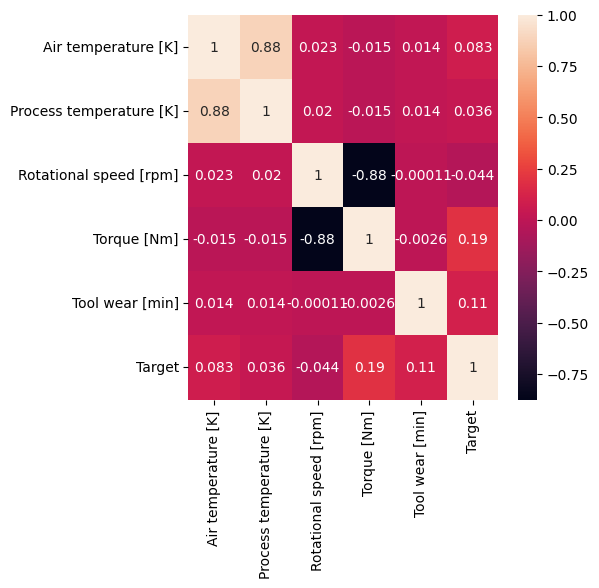

In [11]:
plt.figure(figsize=(5,5))
#Kita buat heatmap menggunakan seaborn
sns.heatmap(df.corr(), annot=True)
plt.show

### PREPROCESSING DATA DENGAN CARA SCALING (STANDARD SCALER)

In [14]:
SS = StandardScaler()
data_hasil_scale = SS.fit_transform(df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])
data_hasil_f = pd.DataFrame(data_hasil_scale, columns=['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
df.drop(['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'], axis=1, inplace=True)
df_scaled = pd.concat([df, data_hasil_f], axis=1)

df_scaled.head()

,Target,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0,-0.951417,-0.946356,0.067484,0.283054,-1.695647
1,0,-0.901428,-0.878954,-0.729604,0.634238,-1.648511
2,0,-0.951417,-1.013759,-0.227940,0.945286,-1.617087
3,0,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664
4,0,-0.901428,-0.878954,-0.729604,0.002108,-1.554240


### KITA PISAHKAN DATA UJI DAN DATA LATIH DENGAN TRAIN TEST SPLIT SERTA STRATIFIED

In [17]:
x = df_scaled.drop(['Target'], axis=1)
y = df_scaled['Target']

#Kita kan bagi data latihan dan uji
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=30)

for train_i, test_i in sss.split(x,y):
    X_train, X_test = x.loc[train_i], x.loc[test_i]
    y_train, y_test = y.loc[train_i], y.loc[test_i]

y_train

8126    0
1591    0
8018    0
8774    0
4334    0
       ..
4764    0
619     0
6513    0
9481    0
994     0
Name: Target, Length: 7479, dtype: int64

### LAKUKAN FITTING MODEL DENGAN DATA LATIH

In [18]:
model = LinearSVC()
#Kita fitting dengan data train atau data latih
model = model.fit(X_train, y_train)

c:\Users\ICS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### KEMUDIAN PREDICT NILAI UJI

In [19]:
hasil_predict = model.predict(X_test)
hasil_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### BUAT CLASSIFICATION REPORT

In [21]:
print("Hasil Klasifikasi")
print(classification_report(y_test, hasil_predict))
print('='*50)

Hasil Klasifikasi
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2411
           1       0.88      0.08      0.15        83

    accuracy                           0.97      2494
   macro avg       0.92      0.54      0.57      2494
weighted avg       0.97      0.97      0.96      2494



##### F1 SCORE MASIH KURANG BAGUS, SEHINGGA PERLU DILAKUKAN OVERSAMPLING DENGAN SMOTE

In [22]:
SMOTE_oversampling = SMOTE(random_state=30, n_jobs=-1)
X_train_hasil_sampling, y_train_hasil_sampling = SMOTE_oversampling.fit_resample(X_train,y_train)

c:\Users\ICS\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


### KITA FIT ULANG DAN PREDIKSI ULANG

In [23]:
#Kita buat model baru, bukan svm tapi random forest
model_rdf = RandomForestClassifier(random_state=30, criterion='entropy')
model_resampled = model_rdf.fit(X_train_hasil_sampling, y_train_hasil_sampling)
hasil_predict_resampeld = model_resampled.predict(X_test)
hasil_predict_resampeld

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

### KITA CEK SKOR NYA

In [24]:
print("Hasil Klasifikasi RF dan setelah di OverSampling")
print(classification_report(y_test, hasil_predict_resampeld))
print('='*50)

Hasil Klasifikasi RF dan setelah di OverSampling
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2411
           1       0.51      0.76      0.61        83

    accuracy                           0.97      2494
   macro avg       0.75      0.87      0.80      2494
weighted avg       0.98      0.97      0.97      2494

